In [1]:
import importlib as il

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from ipydex import Container
import symbtools as st
import pyblocksim as pbs
import boasim as bs

import original_curves as oc
from original_curves import apx

t, s = pbs.t, pbs.s
%matplotlib inline
%load_ext ipydex.displaytools

import time
print(time.ctime())

Thu Dec  5 15:36:16 2024


In [2]:
T = pbs.td.T
T_end = 12
# respect discrete time

tt = np.arange(0, int(T_end/T) + 1)*T

### Propofol as Bolus

Referring to slide 24 and following

Text(0, 0.5, 'relative sensitivity\n (relevant for BIS)')

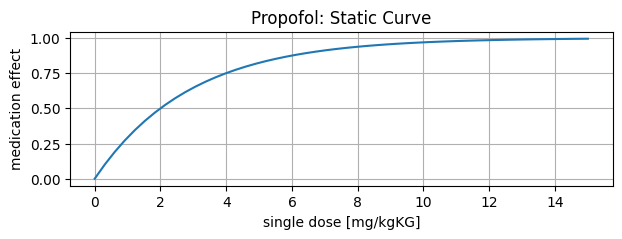

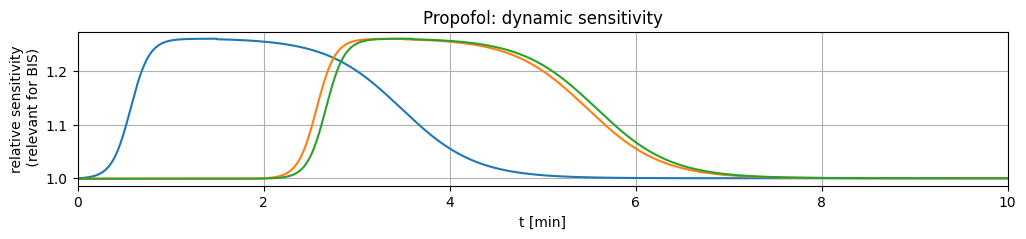

In [3]:
# preparation

il.reload(oc)
il.reload(pbs.td)


params = dict(reference_bp=100, reference_bis=1)
pfl = bs.dtPropofolBolus(input1=0, input2=0, params=params)

dd = np.linspace(0, 15)

plt.figure(figsize=(7, 2))
plt.grid()
plt.plot(dd, pfl.propofol_bolus_static_values_np(dd))
plt.title("Propofol: Static Curve")
plt.xlabel("single dose [mg/kgKG]")
plt.ylabel("medication effect")


tt = np.linspace(0, 20, 5000)

plt.figure(figsize=(12, 2))


plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt))
plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt-2))
plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt-2.1))
plt.xticks(range(0, 20, 2))
plt.xlim(0, 10)
plt.grid()

plt.title("Propofol: dynamic sensitivity")
plt.xlabel("t [min]")
plt.ylabel("relative sensitivity\n (relevant for BIS)")
    
    

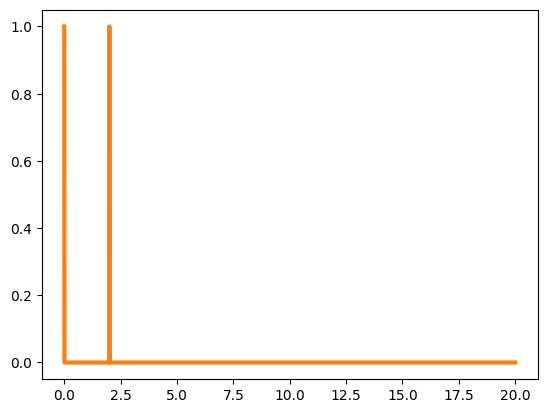

In [4]:
# table from slide 30
# input signal of boli
# original: u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0)), (1.5, apx(t, 2)), (0, True))
u_expr_propofol_boli = sp.Piecewise((1, apx(t, 0)), (1, apx(t, 2)), (0, True))
u_func = st.expr_to_func(t, u_expr_propofol_boli)

plt.plot(tt, u_func(tt), "-", color="tab:orange", lw=3)


In [5]:
def plot_results():
    """
    Plot function to visualize internals of Propofol-Block
    """

    single_dose_effect_dynamics_func = st.expr_to_func(pbs.td.t, pfl.effect_dynamics_expr)
    
    fig, axes = plt.subplots(8, 1, figsize=(15, 15))
    # ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes
    axes = list(axes)

    # current ax
    cax = axes.pop(0)
    cax.plot(kk*T, xx[:, counter_idcs], label="counters")
    cax.legend()

    # cax = axes.pop(0)
    # cax.plot(kk*T, pfl.propofol_bolus_sensitivity_dynamics_np(6-xx[:, counter_idcs].T*T), label="isolated sensitivity")
    # cax.legend()

    cax = axes.pop(0)
    cax.plot(kk, xx[:, bp_amplitude_idcs], ".-", ms=1, label="bp partial doses")
    #ax4.plot(kk, xx[:, 3], "-k")
    #ax4.plot(kk, u_func(kk*T), "-", color="magenta", lw=0.5)
    cax.legend()
    cax.grid()
    
    # plot bp effects of single dose
    cax = axes.pop(0)
    ax = cax
    for idx_c, idx_bpa in zip(counter_idcs, bp_amplitude_idcs):
        counter_time = xx[:, idx_c]*T
        ee = single_dose_effect_dynamics_func(counter_time)*xx[:, idx_bpa]
        # ax.hlines([-8, -18.6], 0, 120, color="0.5", alpha=0.3)
        ax.plot(kk, ee, ".-", ms=1, label="effective dose in blood (single dose, bp)")
        ax.legend()

    cax = axes.pop(0)
    cax.plot(kk*T, bo[bp_delay_block], label="bp effect")
    cax.legend()
    cax.grid()

    cax = axes.pop(0)
    cax.plot(kk*T, xx[:, get_idcs(pfl.x2)], label="combined sensitivity for bis")
    cax.grid()
    # also plot the bolus time points
    cax2 = cax.twinx()
    cax2.plot(tt, u_func(tt), "-", color="tab:orange", lw=1, label="bolus doses")
    
    cax.set_ylim(.98, 1.31)
    cax.set_ylabel("sensitivity")
    cax2.set_ylabel("dose [mg/kgKG]")

    # combined legend (ask matplotlib for the plotted objects and their labels)
    lines, labels = cax.get_legend_handles_labels()
    lines2, labels2 = cax2.get_legend_handles_labels()
    cax.legend(lines + lines2, labels + labels2, loc=0)
    
    cax = axes.pop(0)
    cax.plot(kk, xx[:, bis_amplitude_idcs], ".-", ms=1, label="bis partial doses")
    cax.legend()
    cax.grid()

    
    
    # plot bp effects of single dose
    cax = axes.pop(0)
    ax = cax
    for idx_c, idx_bis in zip(counter_idcs, bis_amplitude_idcs):
        counter_time = xx[:, idx_c]*T
        ee = single_dose_effect_dynamics_func(counter_time)*xx[:, idx_bis]
        ax.plot(kk, ee, ".-", ms=1, label="effective dose in blood (single dose, bis)")
        ax.legend()

    
    cax = axes.pop(0)
    cax.plot(kk*T, bo[bis_sum], label="bis effect (absolute)", lw=2)
    cax.plot(kk*T, xx[:, get_idcs(pfl.x6)], label="bis effect relative")
    cax.legend()
    cax.grid()

    if 0:
        cax = axes.pop(0)
        cax.set_title("debug")
        x3_index = get_idcs(pfl.x3)
        cax.plot(kk, xx[:, x3_index], "-", label="x3_c_ppf_ib_bp")
        cax.legend()
        cax.grid()


# will be used below
def get_idcs(symbs):
    if isinstance(symbs, sp.Symbol):
        symbs = (symbs,)
    assert isinstance(symbs, (list, tuple))
    
    idcs = np.array([i for (i, s) in enumerate(pbs.td.ds.all_state_vars) if sp.sympify(s) in symbs])
    return idcs


In [6]:

il.reload(oc); il.reload(pbs.td); il.reload(bs);

dt = 1

bp_normal = 100
u_func = st.expr_to_func(t, u_expr_propofol_boli)

l1 = pbs.td.get_loop_symbol()
l2 = pbs.td.get_loop_symbol()
bp_sum  = pbs.td.StaticBlock(output_expr=100 + l1)
bis_sum  = pbs.td.StaticBlock(output_expr=1 + l2)
bp_delay_block = pbs.td.dtDelay1(input1=bp_sum.Y)


# dtPropofolBolus - output: Propfol-related BP difference, BIS difference
params = dict(reference_bp=bp_normal, reference_bis=1)
pfl = bs.dtPropofolBolus(input1=u_expr_propofol_boli, input2=bp_delay_block.Y, params=params)
# MAP feedback
pbs.td.set_loop_symbol(l1, pfl.Y[0])

# BIS feedback
pbs.td.set_loop_symbol(l2, pfl.Y[1])

T_end = 12
N_steps = int(T_end/T)

bp_start = bp_normal
iv = {bp_delay_block.x1:bp_start, pfl.x1: 0, pfl.x2: 1}

kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv, rhs_options={"use_sp2c": False})

counter_symbols = pfl.counter_states[::3]

all_idcs = np.arange(len(pbs.td.ds.all_state_vars))
counter_idcs = get_idcs(counter_symbols) ##:


counter_idcs := array([ 8, 11, 14])

---

bis_amplitude_idcs := array([ 9, 12, 15])

---

bp_amplitude_idcs := array([10, 13, 16])

---

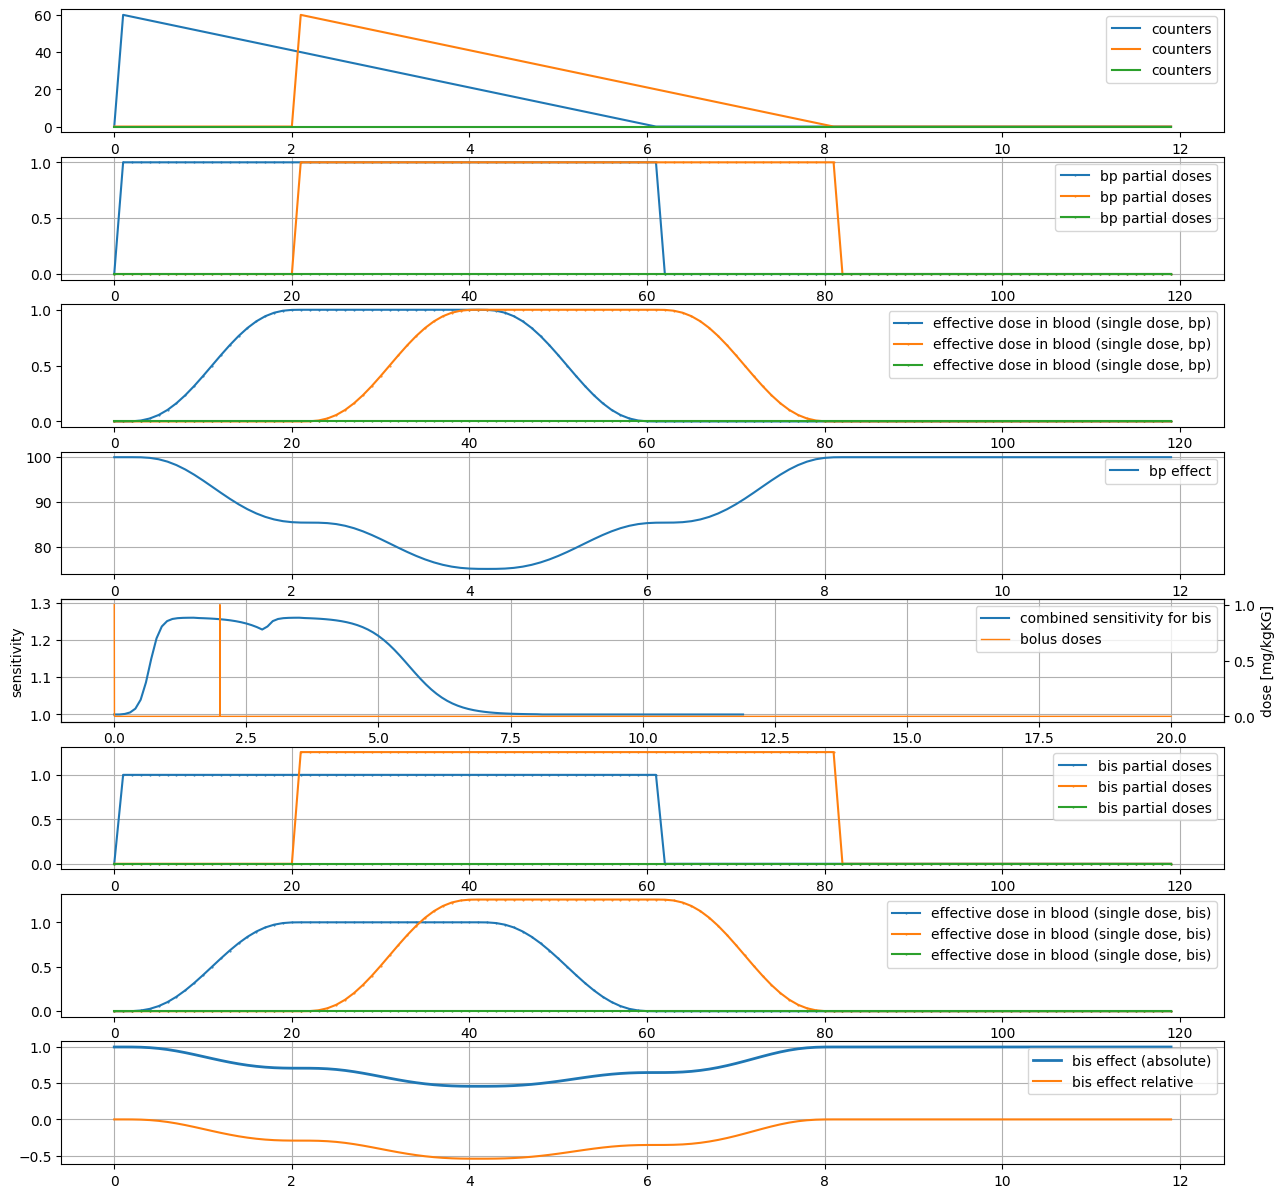

In [7]:
bis_amplitude_idcs = counter_idcs + 1 ##:
bp_amplitude_idcs = counter_idcs + 2 ##:


plot_results()
plt.savefig("all_curves.png")

## Doses according slide 26

(combination of boli and continuous application)

In [ ]:
# WIP: getting continuous block work consistent to bolus block

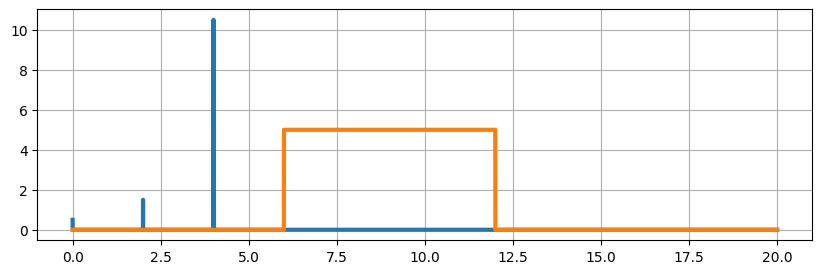

In [16]:
u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0)), (1.5, apx(t, 2)), (10.5, apx(t, 4)), (0, True))
u_func_boli = st.expr_to_func(t, u_expr_propofol_boli)

u_expr_propofol_cont = sp.Piecewise((0, t < 6), (5, t < 12), (0, True))
u_func_cont = st.expr_to_func(t, u_expr_propofol_cont)

plt.figure(figsize=(10, 3))
plt.plot(tt, u_func_boli(tt), "-", color="tab:blue", lw=3)
plt.plot(tt, u_func_cont(tt), "-", color="tab:orange", lw=3)
plt.grid()

In [24]:
il.reload(oc); il.reload(pbs.td); il.reload(bs);

params = dict(rr0=100, fp=6, hf0=80)
pfl_c = bs.PropofolCont(input1=u_expr_propofol_cont, params=params)
kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv, rhs_options={"use_sp2c": False})

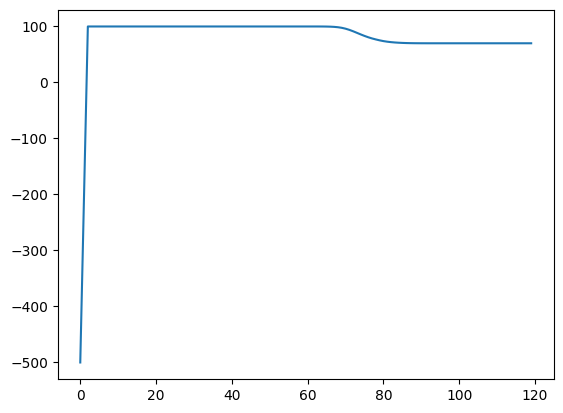

In [28]:
ax = plt.gca()
ax.plot(kk.T, bo[pfl_c][:, 0])

In [ ]:
il.reload(oc); il.reload(pbs.td); il.reload(bs);

dt = 1

bp_normal = 100
u_func = st.expr_to_func(t, u_expr_propofol_boli)

l1 = pbs.td.get_loop_symbol()
l2 = pbs.td.get_loop_symbol()
bp_sum  = pbs.td.StaticBlock(output_expr=100 + l1)
bis_sum  = pbs.td.StaticBlock(output_expr=1 + l2)
bp_delay_block = pbs.td.dtDelay1(input1=bp_sum.Y)


# dtPropofolBolus - output: Propfol-related BP difference, BIS difference
params = dict(reference_bp=bp_normal, reference_bis=1)
pfl = bs.dtPropofolBolus(input1=u_expr_propofol_boli, input2=bp_delay_block.Y, params=params)
# MAP feedback
pbs.td.set_loop_symbol(l1, pfl.Y[0])

# BIS feedback
pbs.td.set_loop_symbol(l2, pfl.Y[1])

T_end = 12
N_steps = int(T_end/T)

bp_start = bp_normal
iv = {bp_delay_block.x1:bp_start, pfl.x1: 0, pfl.x2: 1}

kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv, rhs_options={"use_sp2c": False})

counter_symbols = pfl.counter_states[::3]

all_idcs = np.arange(len(pbs.td.ds.all_state_vars))
counter_idcs = get_idcs(counter_symbols) ##: